# US market analysis

## Import and cleaning data

### Import data ship price border

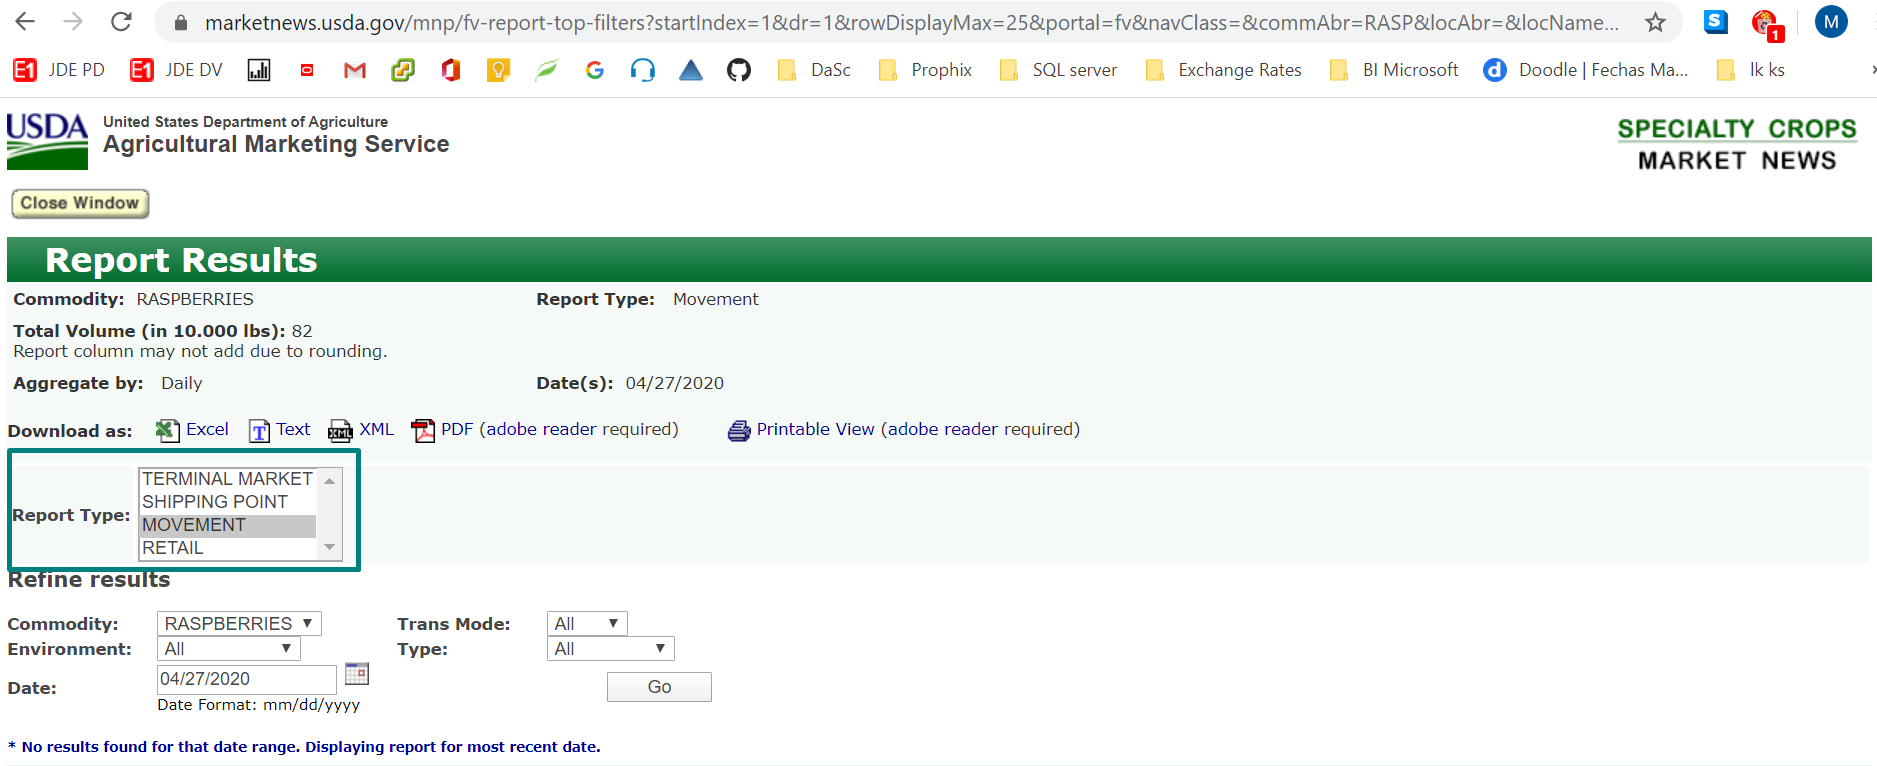

In [1]:
from IPython.display import Image
Image("Data/Website.png")

In [1]:
crop = 'BLUEBERRIES'
conv_package_desc = 'flats 12 6-oz cups with lids'
conv_package_un = 72 * 0.0283495
crop_abb = 'BLUBY'
lb_to_kg = 0.453592

In [1]:
crop = 'RASPBERRIES'
crop_abb = 'RASP'
conv_package_desc = 'flats 12 6-oz cups with lids'
conv_package_un = 72 * 0.0283495
lb_to_kg = 0.453592 #0.0283495*72

In [95]:
crop = 'STRAWBERRIES'
crop_abb = 'STRBY'
conv_package_desc = 'flats 8 1-lb containers with'
conv_package_un = 8 * 0.453592
lb_to_kg = 0.453592 #0.0283495*72

In [96]:
# Importing libraries 
import pandas as pd
from datetime import date
import numpy as np

# Setting dates
# Date from
fday = '01'
fmonth = '01'
fyear = '2010'

# Date to : current date data to collect updated information
tday = date.today().strftime('%d')
tmonth = date.today().strftime('%m')
tyear = date.today().strftime('%Y')

# URL for accessing prices
USprices = f"https://www.marketnews.usda.gov/mnp/fv-report-top-filters\
?&commAbr={crop_abb}&varName=&locAbr=&repType=shipPriceDaily\
&navType=byComm&locName=&navClass=&type=shipPrice&dr=1&volume=&commName={crop}&navClass,=&portal=fv&region=\
&repDate={fmonth}%2F{fday}%2F{fyear}&endDate={tmonth}%2F{tday}%2F{tyear}&format=excel&rebuild=false"
    

# Assign the table data in html format to a Pandas dataframe
table =  pd.read_html(USprices,header=0,parse_dates=['Date'])[0]
  
# Store the dataframe in Excel file to avoid html tags and save data source file
file_path = f'./Data/{crop}/USMXprices.xls'
table.to_excel(file_path) 

# Read the Excel in a Pandas dataframe
prices = pd.DataFrame()
prices = pd.read_excel(file_path\
                    ,header=0
                    ,usecols= (['Commodity Name',\
                    'City Name',\
                    'Package',\
                    'Date',\
                    'Low Price',\
                    'High Price',\
                    'Mostly Low',\
                    'Mostly High',\
                    'Season',\
                    'Type']))

# Clean data
package = conv_package_desc
prices = prices[(prices['City Name'].astype(str).str[:6] == 'MEXICO') \
       & (prices['Low Price'].notnull()) & (prices['High Price'].notnull()) \
       & (prices['Type'] != 'Organic') \
       & (prices['Package'].astype(str).str[:28] == 'flats 8 1-lb containers with')]
# !!!!!!!!!!!!
# Pendiente añadir condición por tipo package
# !!!!!!!!!!!

prices['Avg Price'] = prices[['Low Price','High Price']].mean(axis=1)
prices = prices[['Date','Low Price','High Price','Avg Price','Season']]
prices['Avg Price'] = prices['Avg Price'] / conv_package_un
prices['Crop']=crop
prices['Country']='US'
prices['Currency']='USD'
prices['Measure']='KG'
campaign_dates = prices.groupby('Season')['Date'].agg('min').reset_index()
campaign_dates.columns = ['Season','First Date']
prices = pd.merge(left=prices, right=campaign_dates, how='left', left_on='Season', right_on='Season')
prices['Season_Week'] = np.ceil((prices['Date'] - prices['First Date']).dt.days.astype('int16')/7).astype(int)
prices['Year'] = prices['Date'].dt.year
prices['Week'] = prices['Date'].dt.week
prices['Week_desc'] = prices['Week'].apply(str) + "-" + prices['Year'].apply(str)
# !!!!!!!!!!!!
# falta update de week_num = 0 a 1 
# !!!!!!!!!!!

In [101]:
import pyodbc
from datetime import datetime

connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

qry_max_date = f"SELECT max(Date_ref) FROM [Prices].[dbo].[prices] where cast([Country] as nvarchar) = cast('US' as nvarchar) and cast([Product] as nvarchar) = cast('{crop}' as nvarchar)"
max_date = pd.read_sql(qry_max_date, connStr)
upd = 0

try:
    for index,row in prices.iterrows():
        if row['Date'] > max_date.loc[0].values[0]: # Python price line date must be greater than the max date in SQL table
            for index,row in prices_complete.iterrows(): # When there are no prices in SQL
                cursor.execute("INSERT INTO dbo.prices([Product],[Price],[Country],[Currency],[Measure],[Date_ref]) values (?,?,?,?,?,?)",row['Crop'],row['Avg Price'],row['Country'],row['Currency'],row['Measure'],row['Date'])
                connStr.commit()
                upd += 1
except TypeError: # If there price is null no posibility to compare operands
    for index,row in prices.iterrows(): # When there are no prices in SQL
        cursor.execute("INSERT INTO dbo.prices([Product], [Price], [Country], [Currency], [Measure], [Date_ref], [Week_desc], [Week_num], [Year_num], [Week_num_campaign], [Year_campaign]) values (?,?,?,?,?,?,?,?,?,?,?)",row['Crop'],row['Avg Price'],row['Country'],row['Currency'],row['Measure'],row['Date'],row['Week_desc'],row['Week'],row['Year'],row['Season_Week'],row['Season'])
        connStr.commit()
        upd += 1
cursor.close()
connStr.close()
print(upd," new prices added")
# !!!!!!!!!!!!
# falta leer del sql los registros, filtrar los últimos x días/meses, borrar y cargar nuevos 
# !!!!!!!!!!!

1754  new prices added
